In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [14]:
df=pd.read_csv('../../Database/DB_v2.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
scaler=StandardScaler()


In [15]:
y=df['DEF_PAY']
X=scaler.fit_transform(df.drop(['DEF_PAY'],axis=1))

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import joblib

In [9]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=10):
    skf = StratifiedKFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs = GridSearchCV(model, cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [10]:

param_grid = {
    'solver': ['adam'],
    'max_iter': [100,300,200],
    'alpha': 10.0** -np.arange(1, 4),
    'hidden_layer_sizes':(70,100,200),
    'activation': ["logistic","tanh"]
}
mlp = MLPClassifier(early_stopping=True)
gs,_,_=gridSearch(mlp,param_grid,X,y,0.2)
joblib.dump(gs, 'gs_object.pkl') #se guarda el gs para su posterior uso

MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=100, max_iter=300)
0.8204583333333334


['gs_object.pkl']

In [46]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report

def experimentar(X,Y):
    """ función para realizar experimentos con el MLP
    x: matriz de numpy con caracteristicas
    y: vector numpy con las variables a predecir
    num_hidden_layers: list de enteros con el numero de capdas
        ocultas a usar
    num_neurons: list de enteros con el numero de neuronas a usar
    
    Retorna: dataframe con 4 columnas:
        - numero de capas, numero de neuronas
        - promedio de error prueba (exactitud/eficiencia) de claisficacion y desviación estandar        
    """
    #Validamos el modelo
    Folds = 10
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=100, max_iter=300)

        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1)) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2337
           1       0.70      0.37      0.48       663

    accuracy                           0.83      3000
   macro avg       0.77      0.66      0.69      3000
weighted avg       0.81      0.83      0.80      3000



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.768223,0.021556,0.660425,0.019058


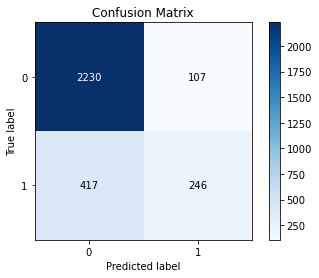

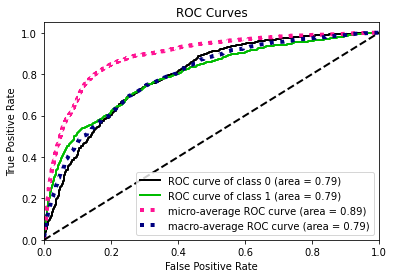

In [47]:
experimentar(X,y)